In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
format_plots()
#format_pizza_plots()

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            cohort_dist[x,y]=scipy.spatial.distance.jensenshannon(p=np.array(i), q=np.array(j))
            
            y=y+1
        y=0
        x=x+1
    #cohort_dist[cohort_dist==0]='nan'
    return cohort_dist

def plot_KLD(cohort_dist,age_labels,vmin=0.1,vmax=0.1,title='distance'):
    # cohort_dist is matrix of
    seqmatcolor='cubehelix'
    cmg=sns.clustermap(cohort_dist,cmap=seqmatcolor,
                       xticklabels=1,
                       yticklabels=1,
                   colors_ratio=0.2,cbar_pos=(1.05, 0.045, 0.03, 0.75),
                   col_cluster=False,row_cluster=False,
                   method='average',metric='sqeuclidean', vmin=vmin,vmax=vmax)
    cmg.fig.set_size_inches(6,6)
    ax = cmg.ax_heatmap
    ax.set_xticklabels(age_labels, fontsize=6)
    ax.set_yticklabels(age_labels)
    #ax.set_yticks([])
    #ax.set_xticks([])
    ax.set_title(title,fontsize=14)
    plt.show()
    #cmg.savefig(data_loc +'long=kld_between_ages.pdf', bbox_inches='tight')

In [6]:
## update data
def filter_df(df):
    max=100
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [7]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
m_data = data.query('age < 95').copy()
#m_data = data.copy()
m_data['sex'] = 'm'

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
f_data = data.query('age < 95').copy()
#f_data = data.copy()
f_data['sex'] = 'f'

In [8]:
data=pd.concat([m_data,f_data])

In [9]:
# plot distance

In [10]:
data=data.groupby(['sex','age']).mean()

In [11]:
data

46        53        5         75        11        0         66  \
sex age                                                                         
f   4    0.002470  0.002425  0.020067  0.006601  0.001624  0.022560  0.002103   
    8    0.003711  0.002664  0.029281  0.005142  0.003278  0.022493  0.004075   
    12   0.005078  0.005523  0.045950  0.004867  0.004651  0.018332  0.004134   
    20   0.006729  0.006032  0.041249  0.003905  0.014275  0.016310  0.003992   
    24   0.007220  0.006165  0.034510  0.002731  0.018303  0.014070  0.001449   
    28   0.005661  0.003172  0.031582  0.002808  0.019190  0.044973  0.001447   
    32   0.008176  0.005770  0.047317  0.002978  0.011461  0.027802  0.001761   
    36   0.006700  0.004542  0.045757  0.003156  0.011841  0.029623  0.003477   
    40   0.006795  0.006077  0.045176  0.002209  0.010339  0.022457  0.003176   
    44   0.008164  0.004955  0.043754  0.002354  0.037331  0.026509  0.002010   
    48   0.009864  0.005792  0.044863  0.001843  0.033454  0.027970  0.002810   
    52   0.011267  0.007144  0.036343  0.002490  0.009271  0.032017  0.001594   
    56   0.008835  0.004643  0.044656  0.002367  0.013309  0.035231  0.000979   
    60   0.009363  0.005510  0.033151  0.001602  0.026282  0.033708  0.001530   
    64   0.008766  0.005323  0.042889  0.001733  0.017875  0.036959  0.000985   
    68   0.006722  0.005000  0.025829  0.001782  0.008771  0.020682  0.002768   
    72   0.012249  0.007183  0.042072  0.002844  0.016498  0.026542  0.001730   
    78   0.010458  0.004245  0.042570  0.001727  0.029154  0.044627  0.001236   
    80   0.010436  0.004307  0.033304  0.001580  0.027168  0.044132  0.001292   
    84   0.010586  0.005368  0.041970  0.002074  0.042552  0.041460  0.001269   
    90   0.012801  0.005663  0.052765  0.002119  0.041482  0.039920  0.001648   
m   4    0.003501  0.003223  0.017935  0.006406  0.003388  0.030775  0.002116   
    8    0.004661  0.005047  0.043710  0.007340  0.007961  0.028168  0.005620   
    12   0.005162  0.003524  0.026740  0.003333  0.021770  0.040014  0.005790   
    16   0.005294  0.005348  0.038673  0.002972  0.027764  0.048536  0.006416   
    20   0.005749  0.005181  0.040175  0.002764  0.027841  0.049727  0.007490   
    24   0.004956  0.005249  0.033771  0.003205  0.030219  0.065768  0.002628   
    28   0.003831  0.004484  0.033533  0.001195  0.028502  0.056703  0.006116   
    32   0.006395  0.003871  0.037809  0.002740  0.023586  0.068105  0.003414   
    36   0.005442  0.004857  0.029260  0.001705  0.025217  0.072574  0.002626   
    40   0.005994  0.005288  0.033399  0.001783  0.030425  0.066779  0.003843   
    44   0.005655  0.003472  0.030045  0.001523  0.031104  0.078031  0.002409   
    48   0.005420  0.003851  0.024166  0.001400  0.027204  0.075087  0.002461   
    52   0.007342  0.004613  0.011809  0.001579  0.015597  0.096030  0.001072   
    56   0.005783  0.003753  0.025442  0.001640  0.020502  0.080931  0.003824   
    60   0.006431  0.005785  0.025947  0.001543  0.025497  0.082003  0.002804   
    64   0.007403  0.004705  0.019170  0.001546  0.026167  0.091522  0.001003   
    68   0.005756  0.003916  0.032204  0.001382  0.038327  0.060993  0.003047   
    72   0.006952  0.005249  0.024772  0.001109  0.021572  0.090110  0.000767   
    78   0.006639  0.004571  0.024715  0.001942  0.023811  0.086013  0.001524   
    80   0.008848  0.005194  0.018243  0.001553  0.025646  0.088021  0.001543   
    84   0.008676  0.005602  0.024503  0.002140  0.031477  0.089632  0.001234   
    90   0.006336  0.003615  0.023943  0.001318  0.020168  0.098217  0.001229   

               3         12        68  ...        89        6         72  \
sex age                                ...                                 
f   4    0.017403  0.028926  0.005260  ...  0.004335  0.008061  0.007762   
    8    0.025321  0.028246  0.004121  ...  0.001929  0.011540  0.004177   
    12   0.022547  0.024219  0.004346  ...  0.001396  0.015967  0

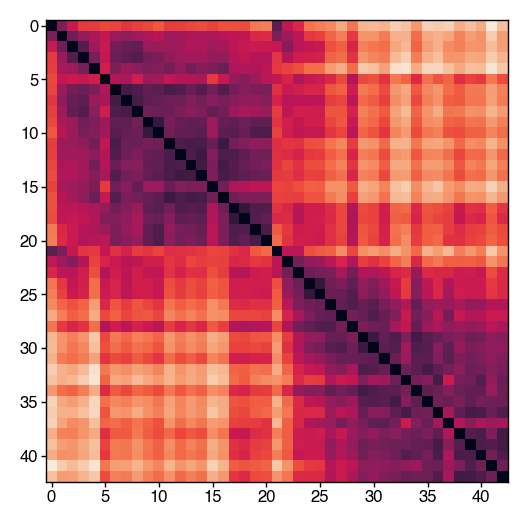

In [12]:
kld = KLD_analysis(data.to_numpy())
plt.imshow(kld)

In [18]:
#colors for plotting
data_labels = data.index.get_level_values('sex').to_numpy()
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='cubehelix'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

<Figure size 1200x1200 with 0 Axes>

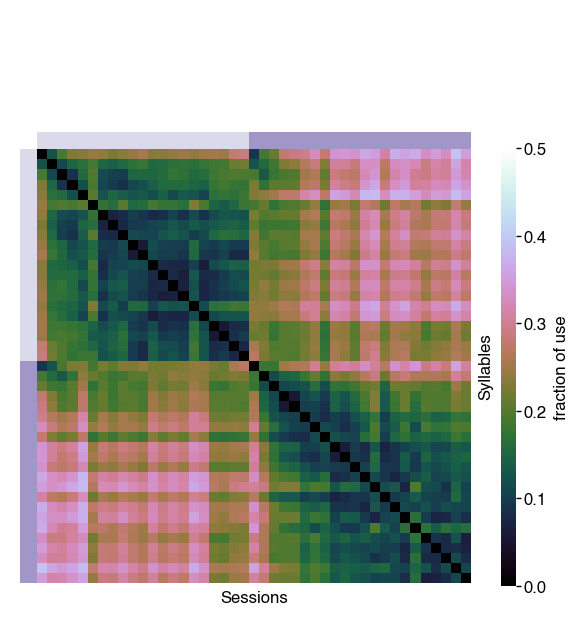

In [19]:
# plot syllable usage acoss time points
figure(4,4)
cg=sns.clustermap(
    data=kld,
    cmap=seqmatcolor, 
    figsize=(3, 3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=False,
    xticklabels=False,
    method='average',
    metric='jensenshannon',
    cbar_kws={'label': 'fraction of use'}, 
    vmin=0.0,
    vmax=0.5,
)
cg.ax_row_dendrogram.set_visible(False)
ax = cg.ax_heatmap
ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Sessions')
ax.set_ylabel('Syllables')
plt.show()
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig4"/ 'fvm_js_distance_cubehelix.pdf', bbox_inches='tight')